In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from L96_model import (
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)
from matplotlib.animation import FuncAnimation

time_method = RK4

In [2]:
# - This is a standard GCM class including a polynomial parameterization in rhs of equation for tendency.
#  In this experiment we will not be using the parameterization in this class but have left it for generality.
class GCM:
    def __init__(self, F, parameterization, time_stepping=RK4):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) + self.parameterization(param, X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [3]:
# - This is the same as the GCM with one notable exception.
#  We have set the advection flag to False in the RHS of the L96 equation.
class GCM_1d:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F, advect=False) + self.parameterization(
            param, X, self.F
        )

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [4]:
# Chose a modest forcing and simulate for 100 cycles
Forcing, dt, T = 10, 0.01, 100
Forcing_x10 = 20  # Forcing*10

# Choose an random set of initial conditions
b = 10
init_cond = b * np.random.randn(8)

# ----------------------------------------------------------------
# We create the template 2d GCM here with the polynomial parameterization
# this model will be used to generate training data to learn the advection term.
naive_parameterization = lambda param, X, F: np.polyval(param, X)
gcm_2d = GCM(Forcing, naive_parameterization)

# ----------------------------------------------------------------
# We also create a super GCM for simulation with the forcing of 100.
# This will be used as the truth when we test the ability of the 1d model with the neural network to
# work outside of the parmameter space it was trained.
gcm_2d_x10 = GCM(Forcing_x10, naive_parameterization)

# ----------------------------------------------------------------
# Finally,we build the 1d GCM including the polynomial parameterization,
# and we create the corresponding super GCM with forcing squared.
gcm_1d = GCM_1d(Forcing, naive_parameterization)
gcm_1d_x10 = GCM_1d(Forcing_x10, naive_parameterization)

In [5]:
# Running the 2d and 1d versions of the GCM and GCM with F=100 ("_x10")

x2d, t2d = gcm_2d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x2d_x10, t2d_x10 = gcm_2d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

x1d, t1d = gcm_1d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x1d_x10, t1d_x10 = gcm_1d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

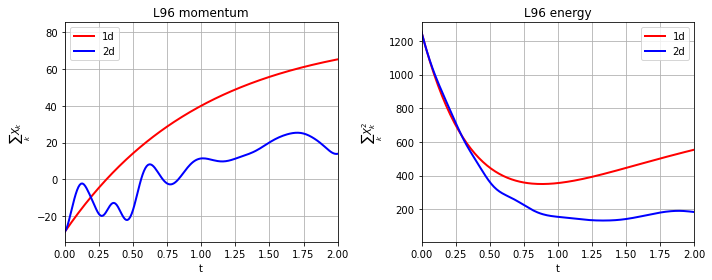

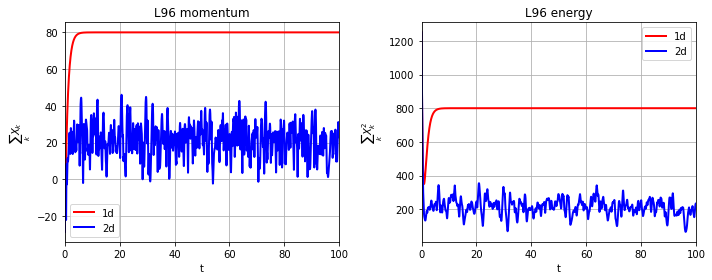

In [6]:
for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(t1d, np.sum(x1d, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(t1d, np.sum(x1d**2, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

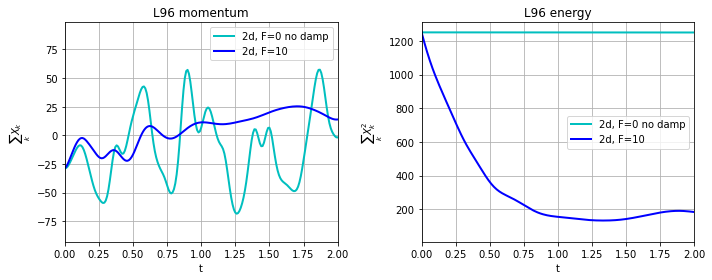

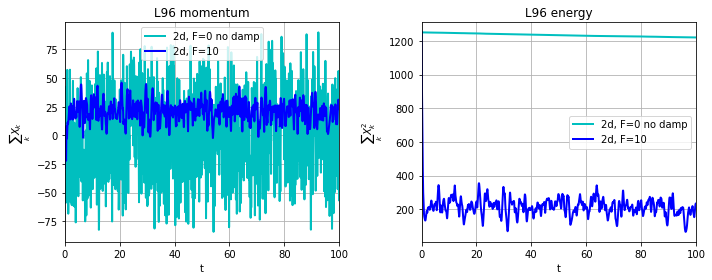

In [7]:
# Zero the forcing
Forcing_demo = 0
# Zero the damping via a linear parameterization term:
P_nodamp = [1.0, 0.0]

# Running the 2d and 1d versions of the GCM and GCM with squared forcing ("s")

gcm_2d_demo = GCM(Forcing_demo, naive_parameterization)
# The parameterization here is countering the decay term to demonstrate the conservation of this system
x2d_demo, t2d_demo = gcm_2d_demo(init_cond, dt, int(T / dt), P_nodamp)


for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo**2, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

In [8]:
# The first set of data to learn is built with the standard forcing

obs = gcm_2d
model = gcm_1d

N = 50000

X = []
Xm1 = []
Xm2 = []
Xp1 = []
Adv = []

# randomize the initial condition and run 1000 time-step spin up with the real world model
init_condr = 10 * np.random.randn(8)
x_2, _ = gcm_2d(
    init_condr,
    0.01,
    1000,
    [
        0.0,
    ],
)

for ti in range(N):

    # Set the initial condition from the spin up/2d model
    init_condr_up = x_2[-1, :]

    # Real world values
    x_2, _ = obs(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )
    # Simple model values
    x_1, _ = model(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )

    # This is the difference in the tendency term due to neglecting 2d processes per time-step
    Adv.append((x_2[-1, :] - x_1[-1, :]).ravel() / dt)

    # Storing the state variable and its rolled forms for plotting and learning convenience
    X.append(x_1[-1, :].ravel())
    Xm1.append(np.roll(x_1[-1, :], 1).ravel())
    Xm2.append(np.roll(x_1[-1, :], 2).ravel())
    Xp1.append(np.roll(x_1[-1, :], -1).ravel())

X = np.array(X)
Xm1 = np.array(Xm1)
Xm2 = np.array(Xm2)
Xp1 = np.array(Xp1)
Adv = np.array(Adv)

In [9]:
# We use a second set of learning data with the F=20 forcing

obs = gcm_2d_x10
model = gcm_1d_x10

N = 50000

X_x10 = []
Xm1_x10 = []
Xm2_x10 = []
Xp1_x10 = []
Adv_x10 = []

# randomize the initial condition and run 1000 time-step spin up with the real world model
init_condr = 10 * np.random.randn(8)
x_2, _ = gcm_2d(
    init_condr,
    0.01,
    1000,
    [
        0.0,
    ],
)

for ti in range(N):

    # Set the initial condition from the spin up/2d model
    init_condr_up = x_2[-1, :]

    # Real world values
    x_2, _ = obs(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )
    # Simple model values
    x_1, _ = model(
        init_condr_up,
        0.01,
        1,
        [
            0.0,
        ],
    )

    # This is the difference in the tendency term due to neglecting 2d processes per time-step
    Adv_x10.append((x_2[-1, :] - x_1[-1, :]).ravel() / dt)

    # Storing the state variable and its rolled forms for plotting and learning convenience
    X_x10.append(x_1[-1, :].ravel())
    Xm1_x10.append(np.roll(x_1[-1, :], 1).ravel())
    Xm2_x10.append(np.roll(x_1[-1, :], 2).ravel())
    Xp1_x10.append(np.roll(x_1[-1, :], -1).ravel())

X_x10 = np.array(X_x10)
Xm1_x10 = np.array(Xm1_x10)
Xm2_x10 = np.array(Xm2_x10)
Xp1_x10 = np.array(Xp1_x10)
Adv_x10 = np.array(Adv_x10)

Text(0, 0.5, 'Advection')

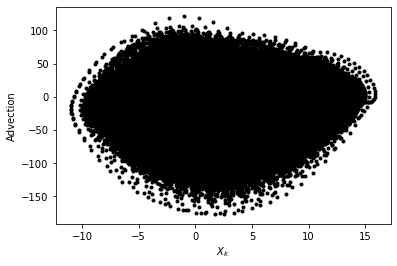

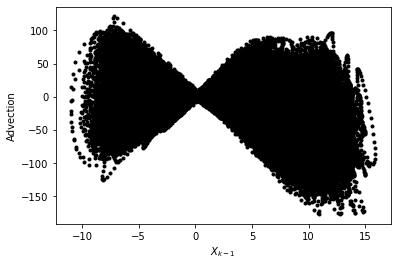

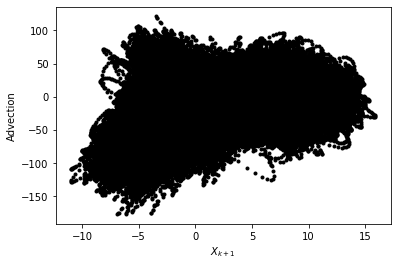

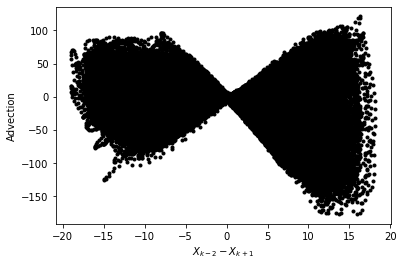

In [10]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_{k}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm1, Adv, "k.")
plt.xlabel("$X_{k-1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xp1, Adv, "k.")
plt.xlabel("$X_{k+1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm2 - Xp1, Adv, "k.")
plt.xlabel("$X_{k-2}-X_{k+1}$")
plt.ylabel("Advection")

Fit (slope/bias):  [ 1.00356256 -0.08315718]


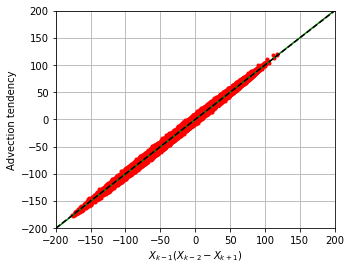

In [11]:
# We are going to assume we know the feature variable that we need to train the model.
# However, because of sampling across a time-step we will not fit a perfect 1:1,
# we end up with something very close to 1:1, but we will use a higher order polynomial that will
# fail when used outside the training data.

# First we will tune with the original F=10 output

plt.figure(figsize=(5, 4))
Feature = -Xm1 * (np.array(Xm2) - np.array(Xp1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$X_{k-1}(X_{k-2}-X_{k+1})$")
plt.ylabel("Advection tendency")

# This parameterization might fail when used outside of the training data.
# Note if we used the Forward Euler timestepping we would get closer to a 1:1 fit for the data.
P = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
print("Fit (slope/bias): ", P)
FS = [-200, 200]
plt.plot(FS, np.polyval(P, FS), "g-", label="polynomial parameterization")
plt.plot(FS, FS, "k--", label="1:1")
plt.xlim(FS)
plt.ylim(FS)
plt.grid(True)

In [12]:
# Create a new 1d GCM with a parameterization for the advection based on the known advection parameter
advection_parameterization = lambda param, X, F: np.polyval(
    param, -np.roll(X, 1) * (np.roll(X, 2) - np.roll(X, -1))
)
gcm_1d_padv = GCM_1d(Forcing, advection_parameterization)
gcm_1d_padv_x10 = GCM_1d(Forcing_x10, advection_parameterization)

# Here is the 1d GCM with the learned advection via the linear parameterization
xplinear, tplinear = gcm_1d_padv(init_cond, dt, int(T / dt), P)

# And the same 1d GCM applied out of sample
xplinear_x10, tplinear_x10 = gcm_1d_padv_x10(init_cond, dt, int(T / dt), P)

In [13]:
def CompExps(Exp1, ExpN):
    # Exp1 - reference experiment list
    # ExpN - list of comparison experiments

    try:
        T1 = Exp1[0]
        X1 = Exp1[1]
        L1 = Exp1[2]
        F, ax = plt.subplots(1, 2, figsize=(10, 4))
        a = ax.ravel()[0]
        a.plot(T1, np.sum(X1, axis=1), label=L1, color="k", linewidth=3)
        a = ax.ravel()[1]
        a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)

        F2, ax2 = plt.subplots(1, figsize=(5, 4))

        for Exp in ExpN:
            TN = Exp[0]
            XN = Exp[1]
            LN = Exp[2]

            a = ax.ravel()[0]
            a.plot(TN, np.sum(XN, axis=1), label=LN, linewidth=2)
            a = ax.ravel()[1]
            a.plot(TN, np.sum(XN**2, axis=1), label=LN, linewidth=2)

            _X = []
            _Y = []
            for ii in range(1, 100, 1):
                _X.append(np.percentile(np.sum(X1[int(5 // dt) :] ** 2, axis=1), ii))
                _Y.append(np.percentile(np.sum(XN[int(5 // dt) :] ** 2, axis=1), ii))
            ax2.plot(_X, _Y, ".-", label=LN)

        for ii in range(2):
            a = ax.ravel()[ii]
            a.legend()
            a.grid(True)
        ax[0].set(ylabel=r"$\sum_k X_k$", xlabel=r"$t$")
        ax[1].set(ylabel=r"$\sum_k X_k^2$", xlabel=r"$t$")
        F.tight_layout()

        ax2.grid(True)
        ax2.set(
            xlabel="e 2d model",
            ylabel="e 1d model w/ param",
            title="q-q plot of energy in 2d and parameterized model",
        )
        LIM = np.nanmax(list(_X) + list(_Y))
        ax2.set_xlim(0, LIM * 1.1)
        ax2.set_ylim(0, LIM * 1.1)
        ax2.plot([0, LIM], [0, LIM], "y-")
        pass
    except:
        pass

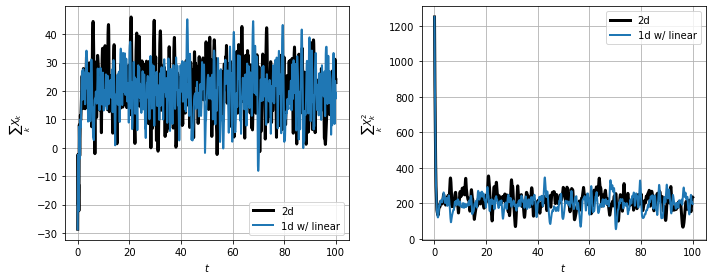

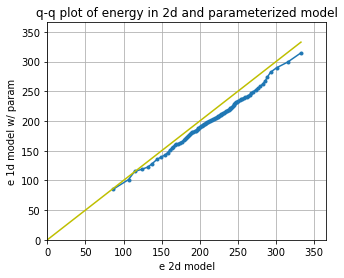

In [14]:
# This (should) learn a stable 'parameterization' for the advection that is very close to the real advection term.

CompExps(
    [t2d, x2d, "2d"],
    [
        [tplinear, xplinear, "1d w/ linear"],
    ],
)

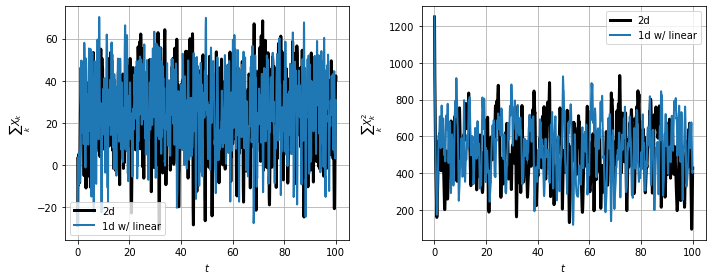

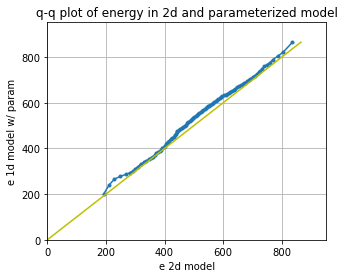

In [15]:
# It even extrapolates to the F=20 model

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tplinear_x10, xplinear_x10, "1d w/ linear"],
    ],
)

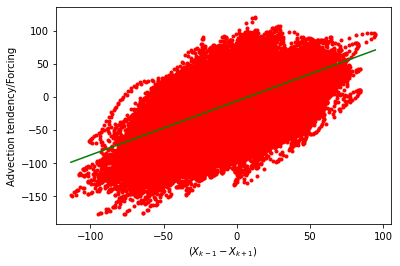

In [16]:
# Now we use a feature that is wrong to train the model

plt.figure()
Feature = -(np.array(Xm2) - np.array(Xp1) * np.array(Xm1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$(X_{k-1}-X_{k+1})$")
plt.ylabel("Advection tendency/Forcing")

P_wrong = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
FS = np.sort(np.array(Feature).ravel())
plt.plot(FS, np.polyval(P_wrong, FS), "g-", label="polynomial parameterization");

/tmp/ipykernel_2531/3080806922.py:3: RuntimeWarning: overflow encountered in multiply
  param, -(np.roll(X, 2) - np.roll(X, -1) * np.roll(X, 1))
/usr/share/miniconda/envs/L96M2lines/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


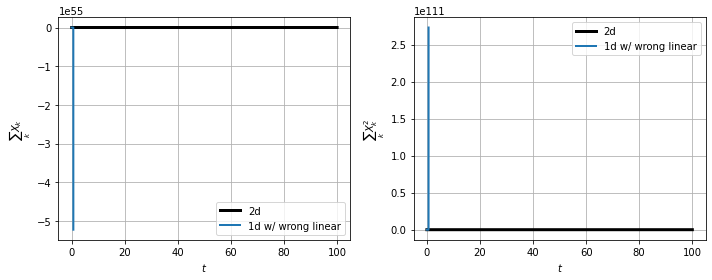

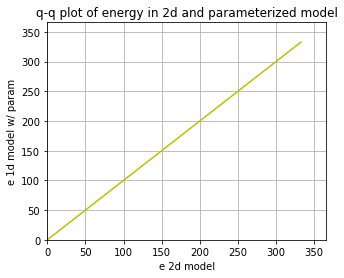

In [17]:
# Create a new 1d GCM with a 2d parameterization
advection_parameterization_wrong = lambda param, X, F: np.polyval(
    param, -(np.roll(X, 2) - np.roll(X, -1) * np.roll(X, 1))
)
gcm_1d_padv_wrong = GCM_1d(Forcing, advection_parameterization_wrong)

# Here is the 1d GCM with the learned advection
x_wrongp, t_wrongp = gcm_1d_padv_wrong(init_cond, dt, int(T / dt), P_wrong)

# This goes unstable very quickly.
# The neural network thus must be trained pretty well to avoid these instabilities.
CompExps(
    [t2d, x2d, "2d"],
    [
        [t_wrongp, x_wrongp, "1d w/ wrong linear"],
    ],
)

In [18]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

Advection RMS: 29.02674698452924
X RMS: 5.158436463474776
Scaled Advection RMS: 0.29026746984529234
Scaled X RMS: 0.5158436463474775
N training data:  40000
N testing data:  10000


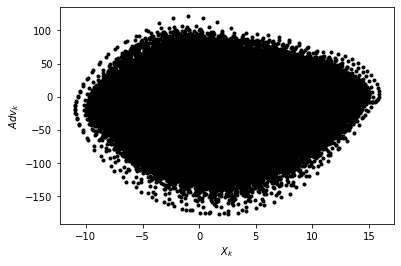

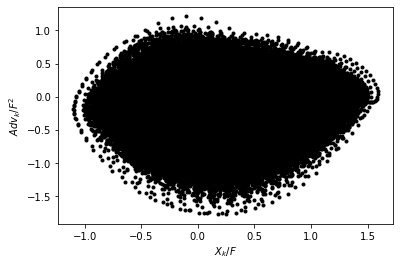

In [19]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_k$")
plt.ylabel("$Adv_k$")

# for F=10
X_F = X / Forcing
Adv_F = Adv / Forcing**2

print("Advection RMS:", np.sqrt(np.mean(Adv**2)))
print("X RMS:", np.sqrt(np.mean(X**2)))

plt.figure()
plt.plot(X_F, Adv_F, "k.")
plt.xlabel("$X_k/F$")
plt.ylabel("$Adv_k/F^2$")

print("Scaled Advection RMS:", np.sqrt(np.mean(Adv_F**2)))
print("Scaled X RMS:", np.sqrt(np.mean(X_F**2)))

# Split into 80% training and 20% testing.

L = int(len(X) * 0.8)

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[:L])).double(),
    torch.from_numpy(np.array(Adv_F[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


print("N training data: ", len(X_F[:L]))


print("N testing data: ", len(X_F[L:]))

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[L:])).double(),
    torch.from_numpy(np.array(Adv_F[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

In [20]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
        # self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [21]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss


criterion = torch.nn.MSELoss()  # MSE loss function

train loss: 0.02931666661280364
validation loss: 0.02943682367828939


train loss: 0.01875437960729584
validation loss: 0.020094635722989106


train loss: 0.014949004636835642
validation loss: 0.016202589250674384


train loss: 0.013845396256378619
validation loss: 0.01485883809013162


train loss: 0.013485365290055404
validation loss: 0.01438761720560088


train loss: 0.012870032682312686
validation loss: 0.013660043044117831


train loss: 0.012585184647864256
validation loss: 0.013603632087006717


train loss: 0.012828134570040048
validation loss: 0.013737147773820322


train loss: 0.012595229694577523
validation loss: 0.01369977065559197


train loss: 0.01222264053043009
validation loss: 0.013235670965922814


train loss: 0.011208114177447749
validation loss: 0.012087519832978429


train loss: 0.013131072344929745
validation loss: 0.013968435643366492


train loss: 0.012405658094934713
validation loss: 0.013439891629027922


train loss: 0.011925091512681604
validation loss: 0.012549319292223074


train loss: 0.01111689283882961
validation loss: 0.012186986998964757


train loss: 0.012189165598387423
validation loss: 0.012737798661074462


train loss: 0.010773907718592282
validation loss: 0.011530979269247389


train loss: 0.010249525437725646
validation loss: 0.011037703516261606


train loss: 0.011043179395166433
validation loss: 0.011916909813334568


train loss: 0.010445096032824569
validation loss: 0.011507097333419807


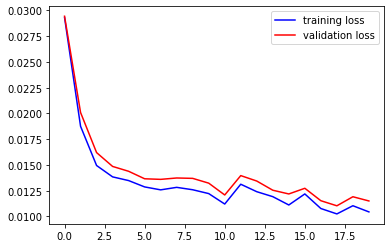

In [22]:
torch.manual_seed(14)  # For reproducibility
nn_3l = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.03)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

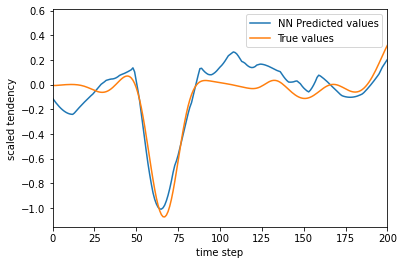

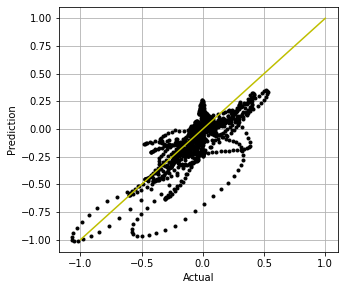

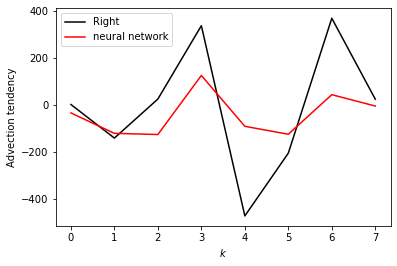

In [23]:
# Look how network does for the tendencies

preds22 = nn_3l(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * Forcing**2, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

In [24]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
# The advection will be set to False
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / self.F).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / self.F, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + self.F**2 * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

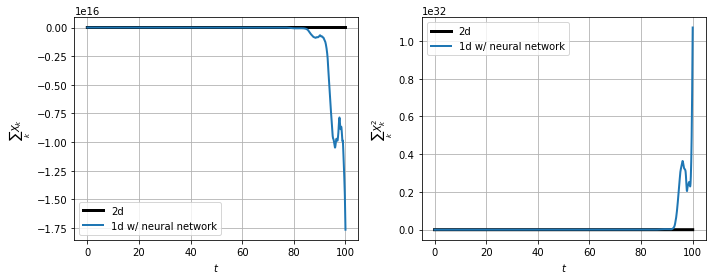

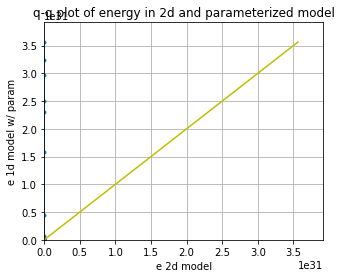

In [25]:
# Run a test with the parameterization
# It takes some time, but usually the network goes unstable eventually

# F=10 model
gcm_nn = GCM_network(Forcing, nn_3l)
xnn, tnn = gcm_nn(init_cond, dt, int(100 / (dt)), nn_3l)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn, xnn, "1d w/ neural network"],
    ],
)

Advection RMS: 29.02674698452924
X RMS: 5.158436463474776
Scaled Advection RMS: 0.19194660186704174
Scaled X RMS: 0.4105046510745612
N training data:  40000
N testing data:  10000


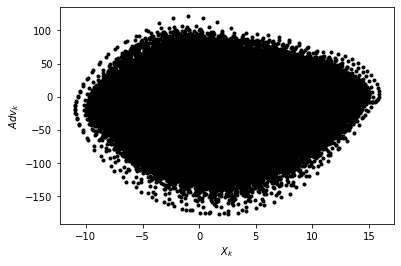

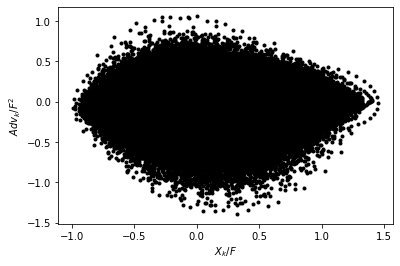

In [26]:
# Try to train the data with slightly higher forcing (will give larger range of advection tendencies to learn)

plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_k$")
plt.ylabel("$Adv_k$")

# for F=20
X_F = X_x10 / Forcing_x10
Adv_F = Adv_x10 / Forcing_x10**2

print("Advection RMS:", np.sqrt(np.mean(Adv**2)))
print("X RMS:", np.sqrt(np.mean(X**2)))

plt.figure()
plt.plot(X_F, Adv_F, "k.")
plt.xlabel("$X_k/F$")
plt.ylabel("$Adv_k/F^2$")

print("Scaled Advection RMS:", np.sqrt(np.mean(Adv_F**2)))
print("Scaled X RMS:", np.sqrt(np.mean(X_F**2)))

# Split into 80% training and 20% testing.

L = int(len(X) * 0.8)

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[:L])).double(),
    torch.from_numpy(np.array(Adv_F[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


print("N training data: ", len(X_F[:L]))


print("N testing data: ", len(X_F[L:]))

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[L:])).double(),
    torch.from_numpy(np.array(Adv_F[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

train loss: 0.016916568971414435
validation loss: 0.017683533127167243


train loss: 0.010940635095835895
validation loss: 0.011834508990656592


train loss: 0.010091913080447287
validation loss: 0.011084067394292511


train loss: 0.009474878836549018
validation loss: 0.010291349147456358


train loss: 0.008661357793216942
validation loss: 0.009421744615772783


train loss: 0.00793954521479717
validation loss: 0.008637398233906506


train loss: 0.00738476898897242
validation loss: 0.007870193004441344


train loss: 0.007657022451235611
validation loss: 0.008133774805968554


train loss: 0.007315257729630498
validation loss: 0.007891752096567586


train loss: 0.007623395027482024
validation loss: 0.008272490734615036


train loss: 0.006687285806132715
validation loss: 0.007122694478626228


train loss: 0.007675495103052281
validation loss: 0.00826359314087252


train loss: 0.006541723775737135
validation loss: 0.0069631876248922725


train loss: 0.006732586283380001
validation loss: 0.007001973633100078


train loss: 0.006769192955964054
validation loss: 0.007158413635737148


train loss: 0.006329972471913225
validation loss: 0.006774391947949697


train loss: 0.00670819037135117
validation loss: 0.0070438789309842775


train loss: 0.006415781644496581
validation loss: 0.006781840807246276


train loss: 0.006359510976177795
validation loss: 0.006727460665869776


train loss: 0.005933610206908902
validation loss: 0.006293137932890484


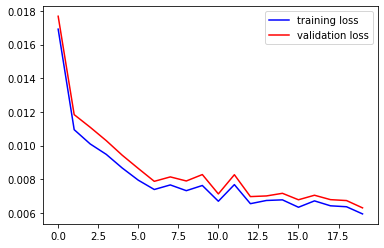

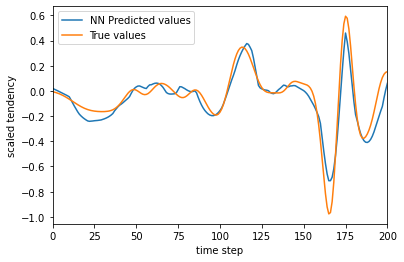

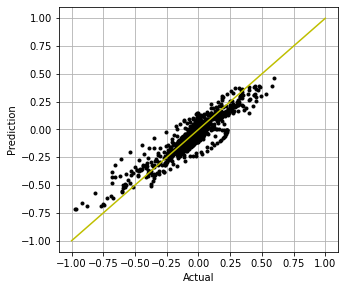

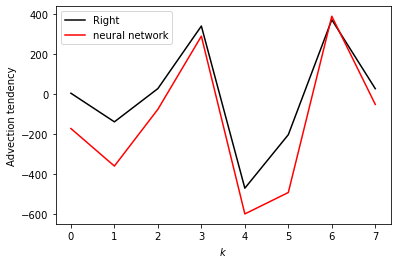

In [27]:
torch.manual_seed(14)  # For reproducibility
nn_3l_x10 = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_x10.parameters(), lr=0.03)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_x10, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_x10, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_x10, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend()

# Look how network does for the tendencies

preds22 = nn_3l_x10(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_x10(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * Forcing_x10**2, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

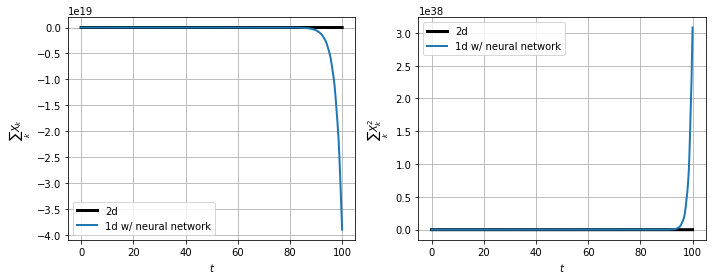

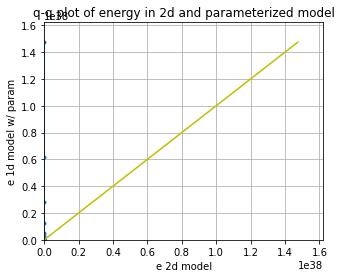

In [28]:
# Run a test with the parameterization built from F=20
# Usually the neural network resulting is much more stable, since it is trained for a wider range of conditions.

# F=10 model
gcm_nn = GCM_network(Forcing, nn_3l_x10)
xnn, tnn = gcm_nn(init_cond, dt, int(100 / (dt)), nn_3l_x10)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn, xnn, "1d w/ neural network"],
    ],
)

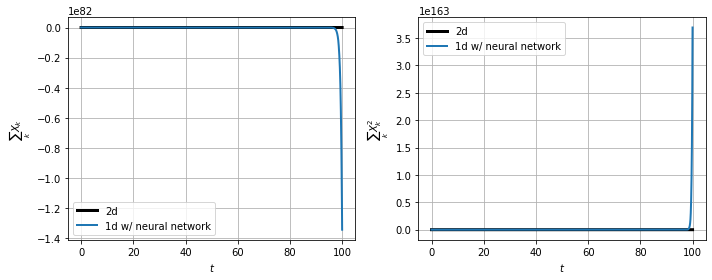

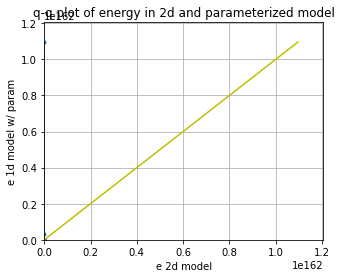

In [29]:
# F=20 model fails still
gcm_nn_x10 = GCM_network(Forcing_x10, nn_3l_x10)
xnn_x10, tnn_x10 = gcm_nn_x10(init_cond, dt, int(100 / (dt)), nn_3l_x10)

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn_x10, xnn_x10, "1d w/ neural network"],
    ],
)

In [30]:
def my_loss2(inpt, output, target):
    # In which we add conservation of "momentum" to our loss function
    loss = torch.mean(2 * (output - target) ** 2) + torch.mean(
        torch.sum(output, axis=1) ** 2
    )
    return loss

In [31]:
# New training routines that use the new loss function


def train_model2(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(b_x, prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model2(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(b_x, prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss

In [32]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss2 = Net_ANN().double()

train loss: 0.07033973352047176
validation loss: 0.06994463979965279


train loss: 0.06052226142500432
validation loss: 0.06084866899207728


train loss: 0.04936527535728145
validation loss: 0.04982267975377732


train loss: 0.04398313673890705
validation loss: 0.04450906200846788


train loss: 0.04045652505715882
validation loss: 0.04114996263450295


train loss: 0.03744186829477144
validation loss: 0.038000927800051945


train loss: 0.03451296268554057
validation loss: 0.03496188000172342


train loss: 0.03295570748097433
validation loss: 0.03350866157992504


train loss: 0.03113242257406603
validation loss: 0.03181646122140366


train loss: 0.02932184674113123
validation loss: 0.03024383949158143


train loss: 0.027753329229998687
validation loss: 0.0288054003398246


train loss: 0.02643301333343731
validation loss: 0.02723691552970121


train loss: 0.02569016832954747
validation loss: 0.02666030143901809


train loss: 0.02580434892311025
validation loss: 0.026577373712596553


train loss: 0.02457530884705073
validation loss: 0.025417332070115532


train loss: 0.025131544696585233
validation loss: 0.025673965992398434


train loss: 0.023775533818272365
validation loss: 0.024501783320901742


train loss: 0.024645030603275407
validation loss: 0.025646121085704094


train loss: 0.02314391344522058
validation loss: 0.024239048859854628


train loss: 0.023716448798533254
validation loss: 0.024384391568722436


train loss: 0.022575579997832045
validation loss: 0.023536153066610783


train loss: 0.022551062965036655
validation loss: 0.023614393694739146


train loss: 0.022590190876298828
validation loss: 0.023481737053578887


train loss: 0.024520458975436747
validation loss: 0.02573784857552856


train loss: 0.022139446626900657
validation loss: 0.023121374068298235


train loss: 0.02275200938468132
validation loss: 0.023654873011367664


train loss: 0.022151753180144628
validation loss: 0.023121502368300892


train loss: 0.021580304565175828
validation loss: 0.022623372652665216


train loss: 0.02339189775103348
validation loss: 0.02422379439835458


train loss: 0.021588654775783745
validation loss: 0.022677970316709536


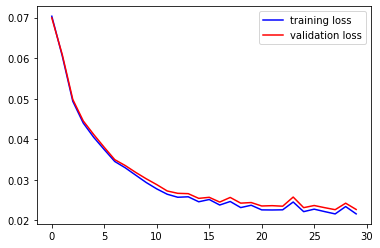

In [33]:
n_epochs = 30  # Number of epocs
optimizer = optim.Adam(nn_3l_loss2.parameters(), lr=0.02)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss2, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss2, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss2, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

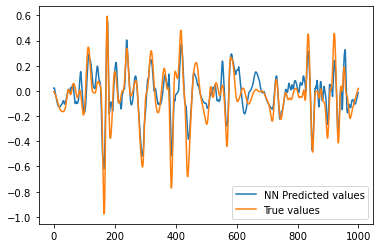

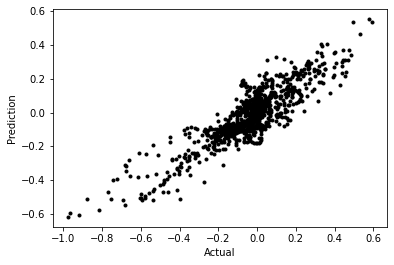

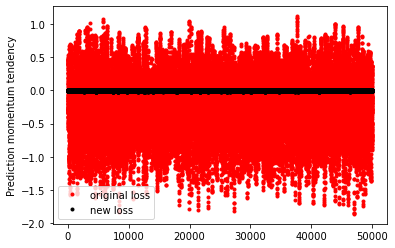

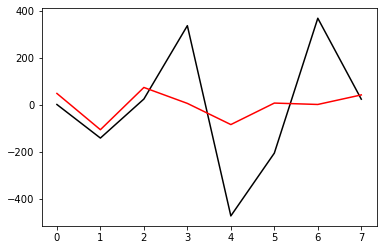

In [34]:
# The neural network now conserves momentum

preds22o = nn_3l(torch.from_numpy(np.array(X_F)).double())
preds22 = nn_3l_loss2(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1), "r.", label="original loss")
plt.plot(np.sum(preds22.detach().numpy(), axis=1), "k.", label="new loss")
plt.ylabel("Prediction momentum tendency")
plt.legend()

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss2(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

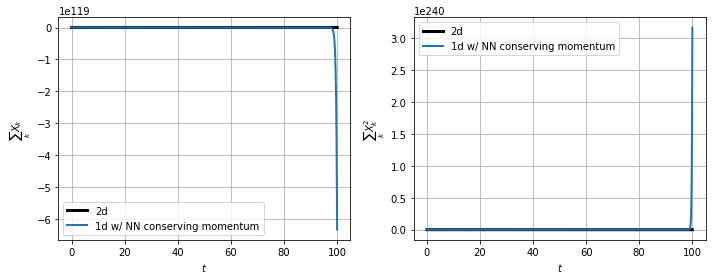

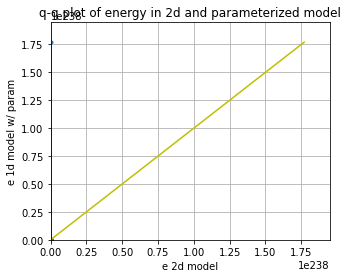

In [35]:
# This didn't help with stabilization...actually seems to hurt

gcm_nn2 = GCM_network(Forcing, nn_3l_loss2)
xnn2, tnn2 = gcm_nn2(init_cond, dt, int(T / (dt)), nn_3l_loss2)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn2, xnn2, "1d w/ NN conserving momentum"],
    ],
)

train loss: 0.027187595719737064
validation loss: 0.027625717935635858


train loss: 0.023375876297283653
validation loss: 0.02356382705476601


train loss: 0.021510614688000803
validation loss: 0.021618750297040124


train loss: 0.019707814244352535
validation loss: 0.020103331737124308


train loss: 0.01960239277632744
validation loss: 0.01984670862573721


train loss: 0.017816480794976188
validation loss: 0.017979074967598648


train loss: 0.017368735575383088
validation loss: 0.01764058999276344


train loss: 0.015518252802458605
validation loss: 0.01591434532228124


train loss: 0.015833493925069764
validation loss: 0.0161694445979967


train loss: 0.015118887044442706
validation loss: 0.015646559242254894


train loss: 0.01485551528897903
validation loss: 0.015289545387775539


train loss: 0.015511389187973013
validation loss: 0.015877700374929044


train loss: 0.01530046909138116
validation loss: 0.015806150069615815


train loss: 0.015110001426747071
validation loss: 0.01558002984985547


train loss: 0.01542390736781061
validation loss: 0.015715628064020378


train loss: 0.01508042046670025
validation loss: 0.015383460052995443


train loss: 0.01569023930644968
validation loss: 0.015733251611334435


train loss: 0.015431654010099726
validation loss: 0.015838490219747075


train loss: 0.015780328197651065
validation loss: 0.016257271092227764


train loss: 0.015375125171394537
validation loss: 0.015601116606609258


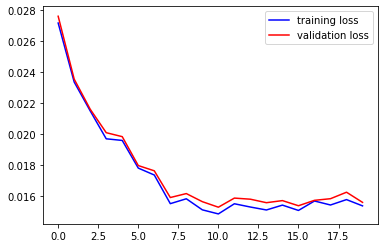

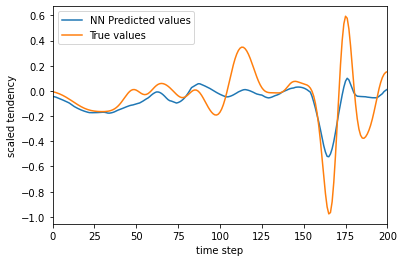

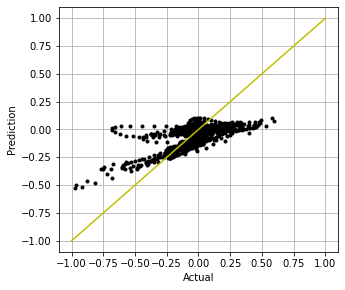

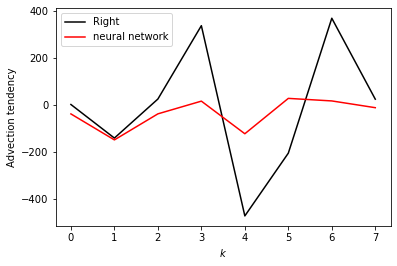

In [36]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss3 = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_loss3.parameters(), lr=0.03, weight_decay=0.0015)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_loss3, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_loss3, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_loss3, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend()

# Look how network does for the tendencies

preds22 = nn_3l_loss3(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_F[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_F[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = (
    nn_3l_loss3(torch.from_numpy(np.array(Xt / Forcing_x10)).double()).detach().numpy()
)

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * Forcing_x10**2, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

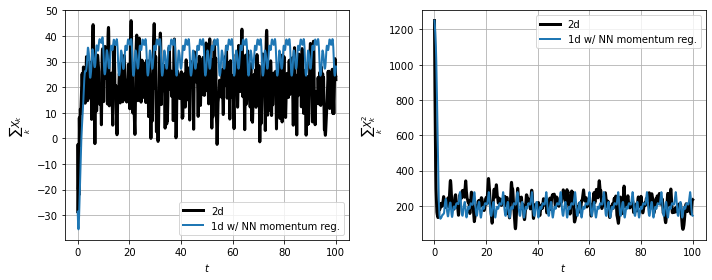

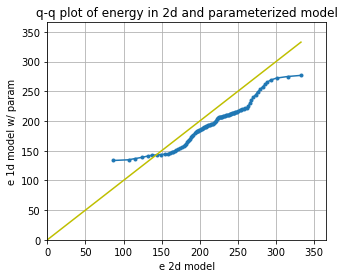

In [37]:
# Weight decay regularization can help with stability, but when it does it sometimes ruins the
# model representation of the actual 'physics'

gcm_nn3 = GCM_network(Forcing, nn_3l_loss3)
xnn3, tnn3 = gcm_nn3(init_cond, dt, int(T / (dt)), nn_3l_loss3)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn3, xnn3, "1d w/ NN momentum reg."],
    ],
)

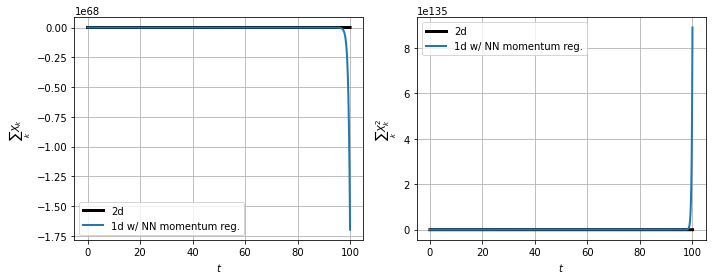

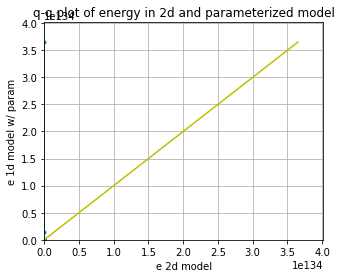

In [38]:
# Here it actually does an okay job of producing the F=20 simulation

gcm_nn3_x10 = GCM_network(Forcing_x10, nn_3l_loss3)
xnn3_x10, tnn3_x10 = gcm_nn3_x10(init_cond, dt, int(T / (dt)), nn_3l_loss3)

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn3_x10, xnn3_x10, "1d w/ NN momentum reg."],
    ],
)

In [39]:
# Use the advection tendencies, splitting into 80% training and 20% testing.

L = int(len(X) * 0.8)
print(L)

ScX = np.sqrt(np.mean(X**2))
X_S = X_x10 / ScX
ScA = np.sqrt(np.mean(Adv**2))
Adv_S = Adv_x10 / ScA

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[:L])).double(),
    torch.from_numpy(np.array(Adv_S[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[L:])).double(),
    torch.from_numpy(np.array(Adv_S[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

40000


train loss: 2.593725846900581
validation loss: 2.688594567894582


train loss: 1.6837096997739462
validation loss: 1.7634169319005646


train loss: 1.3295248682727956
validation loss: 1.420540311520008


train loss: 1.1860991577081823
validation loss: 1.2592485467363923


train loss: 1.1071136190007558
validation loss: 1.1737330705540838


train loss: 1.1246272545576164
validation loss: 1.2104241579561041


train loss: 0.9632784957045427
validation loss: 1.0235757493234892


train loss: 0.9012445202981842
validation loss: 0.9551818579561902


train loss: 0.9227053418725886
validation loss: 0.9988210121159675


train loss: 0.8702294134204109
validation loss: 0.9416331628945548


train loss: 0.8230119645369125
validation loss: 0.8996499794680162


train loss: 0.9015035980558638
validation loss: 0.972894286993218


train loss: 0.8222063052619243
validation loss: 0.8783492638290232


train loss: 0.8608938148846301
validation loss: 0.9197911978083653


train loss: 0.8152679757727757
validation loss: 0.8726711557318906


train loss: 0.7976503222937709
validation loss: 0.8488105477585502


train loss: 0.8954546187566347
validation loss: 0.9473485922745407


train loss: 0.7986643735941933
validation loss: 0.8518690402537945


train loss: 0.7919358529794484
validation loss: 0.8303474794787569


train loss: 0.8153160242755645
validation loss: 0.8546707586563016


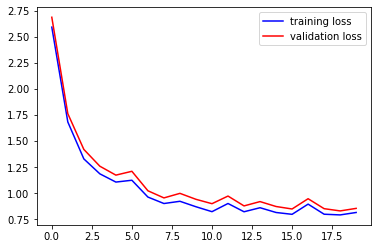

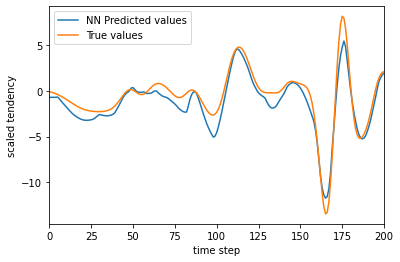

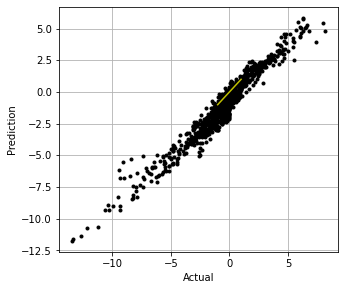

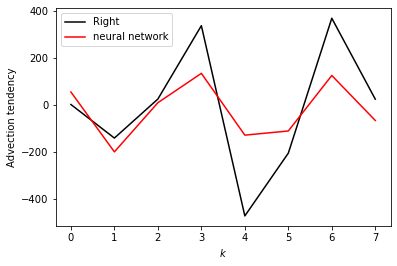

In [40]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss4 = Net_ANN().double()

n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_loss4.parameters(), lr=0.03, weight_decay=0.001)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_loss4, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_loss4, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_loss4, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend()

# Look how network does for the tendencies

preds22 = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_S[:1000, 2], label="True values")
plt.legend()
plt.xlim(0, 200)
plt.ylabel("scaled tendency")
plt.xlabel("time step")

plt.figure(figsize=(5, 4.5))
plt.plot(Adv_S[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.grid(True)
plt.plot([-1, 1], [-1, 1], "y-")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss4(torch.from_numpy(np.array(Xt / ScX)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="Right")
plt.plot(nnAdv * ScA, "r-", label="neural network")
plt.xlabel(r"$k$")
plt.ylabel("Advection tendency")
plt.legend()

In [41]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network_S:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / ScX).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / ScX, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + ScA * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

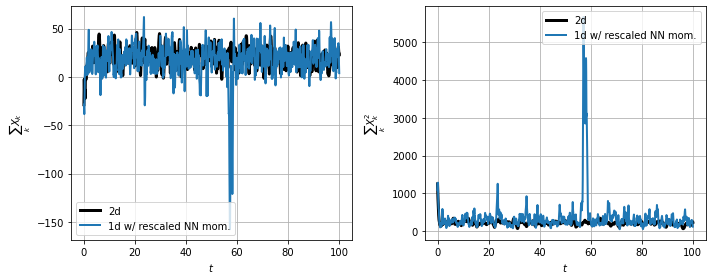

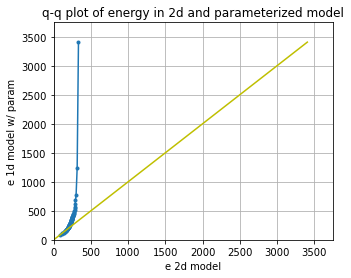

In [42]:
# Usually the network this produces works okay w/ F=10

gcm_nn4 = GCM_network_S(Forcing, nn_3l_loss4)
xnn4, tnn4 = gcm_nn4(init_cond, dt, int(T / dt), nn_3l_loss4)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn4, xnn4, "1d w/ rescaled NN mom."],
    ],
)

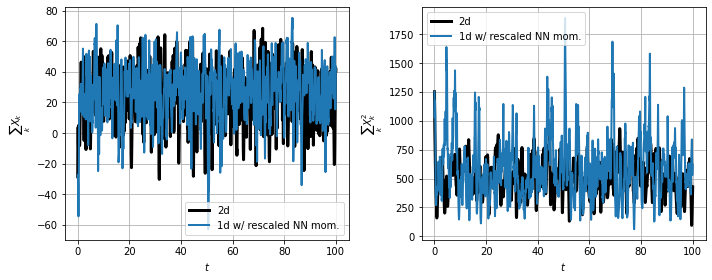

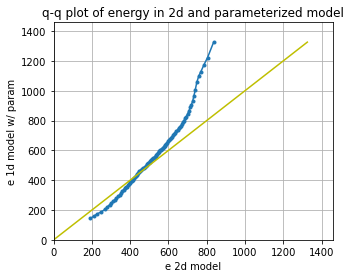

In [43]:
# This might work well for F=20

gcm_nn4_x10 = GCM_network_S(Forcing_x10, nn_3l_loss4)
xnn4_x10, tnn4_x10 = gcm_nn4_x10(init_cond, dt, int(T / dt), nn_3l_loss4)


CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn4_x10, xnn4_x10, "1d w/ rescaled NN mom."],
    ],
)

In [44]:
def my_loss3(inpt, output, target):
    # In which we replace conservation of "momentum" with conservation of "energy"
    loss = torch.mean(2 * (output - target) ** 2) + WT * torch.mean(
        torch.sum(inpt * output, axis=1) ** 2
    )
    return loss

train loss: 11.22357910813178
validation loss: 11.300110291633315


train loss: 9.202636168209754
validation loss: 9.313645325590091


train loss: 8.3047042360697
validation loss: 8.542537076097624


train loss: 7.713652807600963
validation loss: 8.001563292795666


train loss: 7.714182140040906
validation loss: 7.964692107059605


train loss: 7.240464120457064
validation loss: 7.591520662400024


train loss: 7.0700087067842095
validation loss: 7.455517557136112


train loss: 7.148181988599127
validation loss: 7.568491506490001


train loss: 7.014093491248775
validation loss: 7.463296312530121


train loss: 6.66241688213084
validation loss: 7.143915597142358


train loss: 6.517518300764844
validation loss: 7.021994597517851


train loss: 7.10364980555133
validation loss: 7.489138700487136


train loss: 6.331264254605158
validation loss: 6.843541643453145


train loss: 6.497690509217856
validation loss: 6.96634954872331


train loss: 6.803706102124008
validation loss: 7.240768664050623


train loss: 6.236711295928705
validation loss: 6.752187208047988


train loss: 6.27034881104741
validation loss: 6.77179478962118


train loss: 6.232831654033316
validation loss: 6.681708563354638


train loss: 6.054155736188687
validation loss: 6.592536845601964


train loss: 6.056761352144241
validation loss: 6.613523579716016


train loss: 6.323115174018628
validation loss: 6.832389142437653


train loss: 6.021226620239783
validation loss: 6.537257364475477


train loss: 6.493852124477174
validation loss: 6.977341495345779


train loss: 6.051828727108228
validation loss: 6.587032545622807


train loss: 5.990076933034212
validation loss: 6.5376660089469265


train loss: 5.99347630428973
validation loss: 6.5570468342778625


train loss: 5.937630712544735
validation loss: 6.393246799369328


train loss: 6.2478322464397005
validation loss: 6.748535511634971


train loss: 5.813666597623003
validation loss: 6.348018687668354


train loss: 5.826443079010649
validation loss: 6.24977670296241


train loss: 5.784380858813992
validation loss: 6.332012322157419


train loss: 5.676600062813715
validation loss: 6.125605677799559


train loss: 6.1365732939048945
validation loss: 6.674519422358314


train loss: 5.684160715017468
validation loss: 6.124700526732904


train loss: 5.595315893632301
validation loss: 6.089348991106846


train loss: 5.7366939389258045
validation loss: 6.197425145591916


train loss: 5.730124844099963
validation loss: 6.226177547384937


train loss: 5.527375861967755
validation loss: 5.995542162804363


train loss: 5.583031146978528
validation loss: 6.112652268423009


train loss: 5.492942013841332
validation loss: 5.9884767354914015


train loss: 5.290323501681844
validation loss: 5.868874584679339


train loss: 5.397106445602816
validation loss: 5.935564811285494


train loss: 5.401698517845767
validation loss: 5.9484016500562


train loss: 5.885307358689665
validation loss: 6.41486860186222


train loss: 5.3044455361174245
validation loss: 5.821693293450991


train loss: 5.442326638113235
validation loss: 5.96359644196915


train loss: 5.4349312368777785
validation loss: 6.000242012803385


train loss: 5.389931049402433
validation loss: 5.904591107586477


train loss: 5.3317233463358304
validation loss: 5.886151118205575


train loss: 5.24639496449131
validation loss: 5.799028717269975


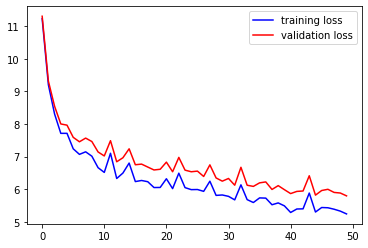

In [45]:
WT = 1

torch.manual_seed(14)  # For reproducibility
nn_3l_loss5 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss5.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss5, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss5, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss5, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

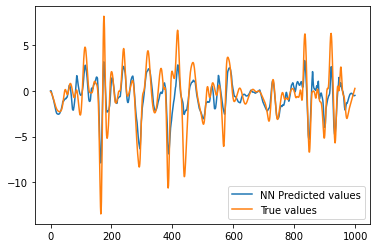

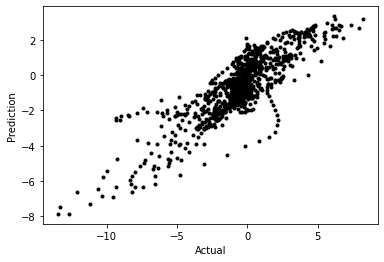

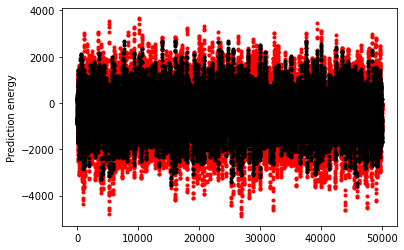

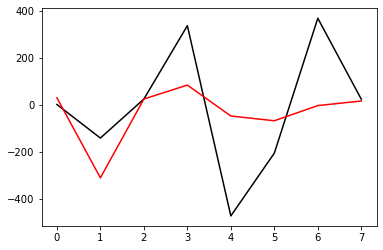

In [46]:
preds22o = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_S[:1000, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy() * ScA, axis=1), "r.")
plt.plot(np.sum(X * preds22.detach().numpy() * ScA, axis=1), "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss5(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

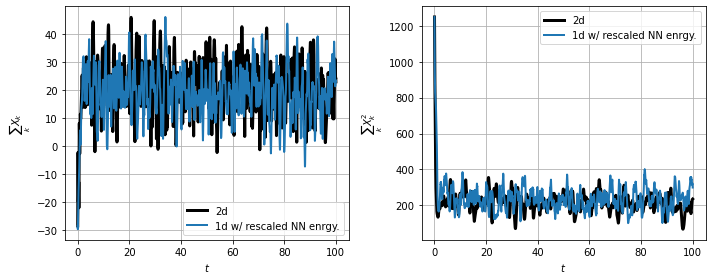

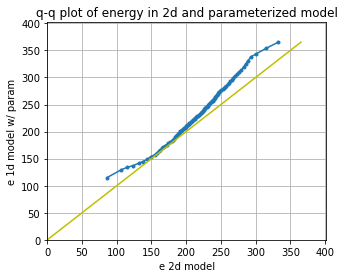

In [47]:
gcm_nn5 = GCM_network_S(Forcing, nn_3l_loss5)
xnn5, tnn5 = gcm_nn5(init_cond, dt, int(T / dt), nn_3l_loss5)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn5, xnn5, "1d w/ rescaled NN enrgy."],
    ],
)

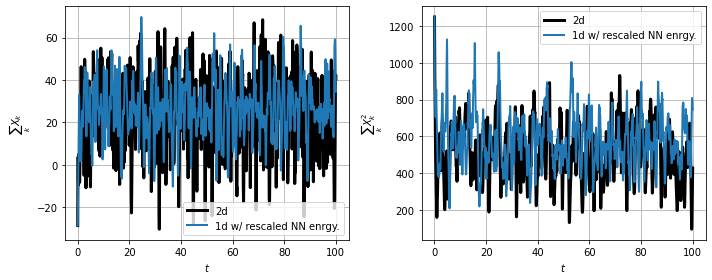

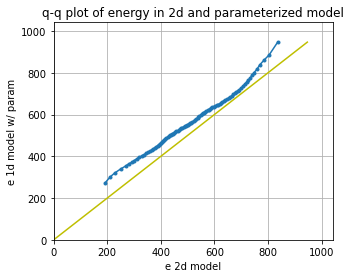

In [48]:
gcm_nn5_x10 = GCM_network_S(Forcing_x10, nn_3l_loss5)
xnn5_x10, tnn5_x10 = gcm_nn5_x10(init_cond, dt, int(T / dt), nn_3l_loss5)


CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn5_x10, xnn5_x10, "1d w/ rescaled NN enrgy."],
    ],
)

train loss: 14.145016059467475
validation loss: 14.144932029570322


train loss: 13.980254852312498
validation loss: 14.055454010805652


train loss: 13.997515074545793
validation loss: 14.049310134577018


train loss: 13.984754371508975
validation loss: 14.021838500785568


train loss: 13.963731797766002
validation loss: 14.019711937867337


train loss: 13.994172749450346
validation loss: 13.996990711295675


train loss: 13.935080700425527
validation loss: 13.971672826899669


train loss: 13.966414290322556
validation loss: 13.96195626066897


train loss: 13.968433128461047
validation loss: 13.937424775512696


train loss: 13.83144697549109
validation loss: 13.918538934360043


train loss: 13.736274347747056
validation loss: 13.856686157893597


train loss: 13.79638135458739
validation loss: 13.789984610212915


train loss: 13.562580771579258
validation loss: 13.636444076704711


train loss: 13.464801378378642
validation loss: 13.529730368017274


train loss: 13.548943888253657
validation loss: 13.506061804768382


train loss: 13.21995079152617
validation loss: 13.278580829267543


train loss: 13.222165396696848
validation loss: 13.162623261447383


train loss: 13.394578389897873
validation loss: 13.383521470165505


train loss: 14.029934750096256
validation loss: 14.182547203231346


train loss: 12.859251823792729
validation loss: 12.87419843024949


train loss: 12.961600801014475
validation loss: 12.96197462640527


train loss: 14.942100936372594
validation loss: 15.072052195462382


train loss: 12.772556535445823
validation loss: 12.792840428866931


train loss: 12.772816388803943
validation loss: 12.851510152657832


train loss: 12.552861272831379
validation loss: 12.616020313813127


train loss: 13.644476861789062
validation loss: 13.693379170490243


train loss: 12.519721296034929
validation loss: 12.495134742825147


train loss: 13.626106940502359
validation loss: 13.863283191920567


train loss: 12.457897640818917
validation loss: 12.50827917944336


train loss: 12.436885457849042
validation loss: 12.473742610142315


train loss: 12.757906432871732
validation loss: 12.736764334708464


train loss: 12.209900118035005
validation loss: 12.242385534551959


train loss: 12.407419915177913
validation loss: 12.465737452019393


train loss: 12.377114850921705
validation loss: 12.398965947104879


train loss: 12.516532434207251
validation loss: 12.652400341570871


train loss: 12.035951682366363
validation loss: 12.105607957781727


train loss: 12.344834877809234
validation loss: 12.500348899007315


train loss: 12.467142674532203
validation loss: 12.633179062242336


train loss: 12.156184300094441
validation loss: 12.149004727768856


train loss: 13.304102473236918
validation loss: 13.426845640000437


train loss: 12.267953075180865
validation loss: 12.389277620032997


train loss: 12.694826006249615
validation loss: 12.989315176928105


train loss: 11.961480975622878
validation loss: 12.052378801003385


train loss: 12.262719159581088
validation loss: 12.340570935651629


train loss: 11.894714788181698
validation loss: 12.02495990549954


train loss: 12.368168329056932
validation loss: 12.450678743977164


train loss: 12.094409221445998
validation loss: 12.194754156614351


train loss: 11.870383433156814
validation loss: 12.012331679265793


train loss: 11.68694523915654
validation loss: 11.797104544880312


train loss: 12.568159290588785
validation loss: 12.582563970238372


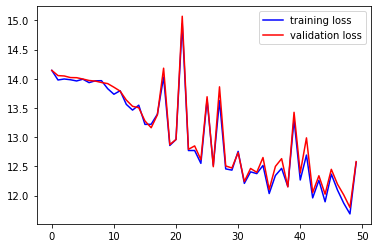

In [49]:
# Try with a higher weight?

WT = 50

torch.manual_seed(14)  # For reproducibility
nn_3l_loss6 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss6.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss6, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss6, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss6, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

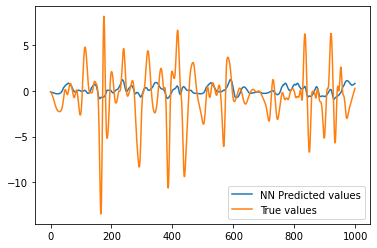

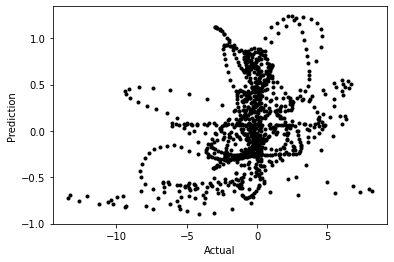

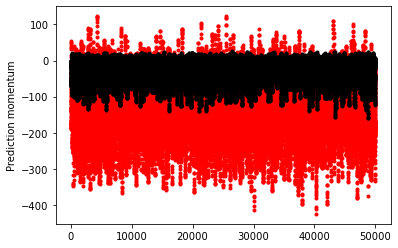

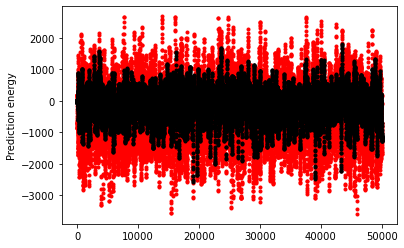

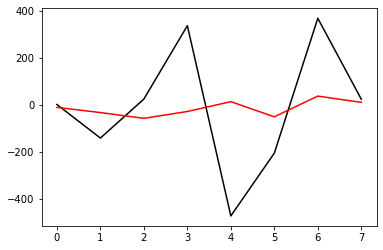

In [50]:
preds22o = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss6(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:1000, 2], label="NN Predicted values")
plt.plot(Adv_S[:1000, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:1000, 2], preds22.detach().numpy()[0:1000, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(X * preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss6(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [51]:
gcm_nn6 = GCM_network_S(Forcing, nn_3l_loss6)
xnn6, tnn6 = gcm_nn6(init_cond, dt, int(T / dt), nn_3l_loss6)

gcm_nn6_x10 = GCM_network_S(Forcing_x10, nn_3l_loss6)
xnn6_x10, tnn6_x10 = gcm_nn6_x10(init_cond, dt, int(T / dt), nn_3l_loss6)

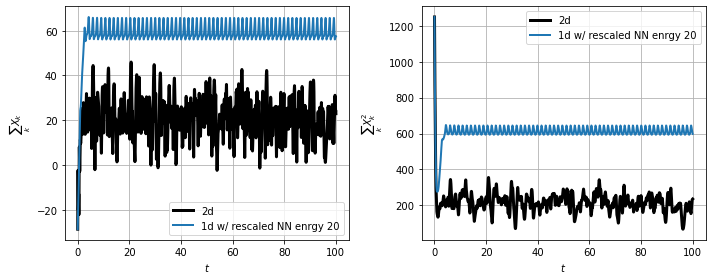

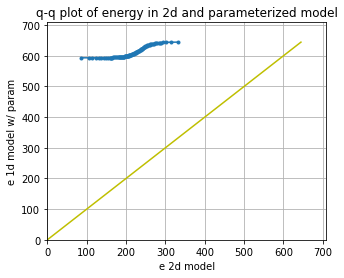

In [52]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn6, xnn6, "1d w/ rescaled NN enrgy 20"],
    ],
)

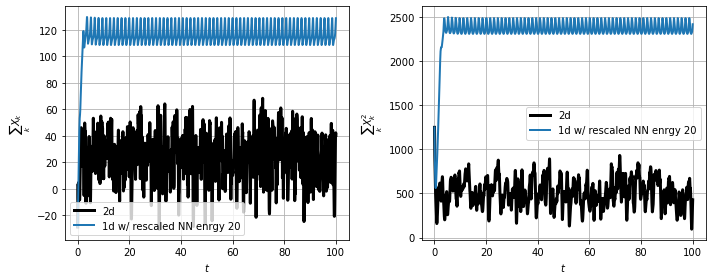

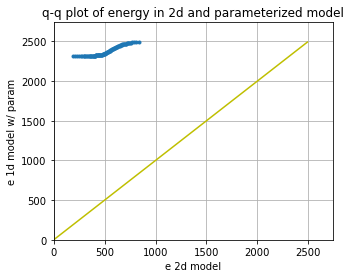

In [53]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn6_x10, xnn6_x10, "1d w/ rescaled NN enrgy 20"],
    ],
)

In [54]:
import torch


def L96_eq1_xdot_NN(X, F, NN, advect=True):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 1:
        d/dt X[k] = -X[k-2] X[k-1] + X[k-1] X[k+1] - X[k] + F

    Args:
        X : Values of X variables at the current time step
        F : Forcing term
    Returns:
        dXdt : Array of X time tendencies
    """

    K = len(X)
    Xdot = np.zeros(K)
    if NN.linear1.in_features == 1:
        X_torch = torch.from_numpy(X / ScX).double()
        X_torch = torch.unsqueeze(X_torch, 1)
    else:
        X_torch = torch.from_numpy(np.expand_dims(X / ScX, 0)).double()

    if advect:
        Xdot = np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) - X + F
    else:
        Xdot = -X + F + ScA * np.squeeze(NN(X_torch).data.numpy())
    #     for k in range(K):
    #         Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F
    return Xdot


# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network_tsNN:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot_NN(
            X, self.F, self.network, advect=False
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

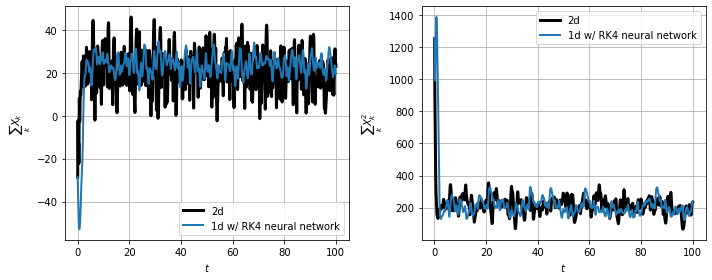

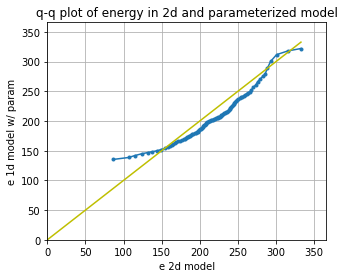

In [55]:
# Run a test with the parameterization

gcm_nnRK = GCM_network_tsNN(Forcing, nn_3l_x10, time_stepping=RK4)
xnnRK, tnnRK = gcm_nnRK(init_cond, dt, int(100 / (dt)), nn_3l)

CompExps(
    [t2d, x2d, "2d"],
    [
        [tnnRK, xnnRK, "1d w/ RK4 neural network"],
    ],
)

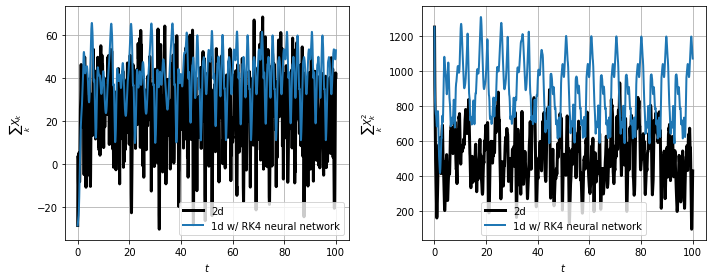

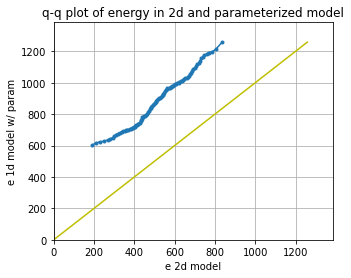

In [56]:
# Run a test with the parameterization

gcm_nnRK_x10 = GCM_network_tsNN(Forcing_x10, nn_3l_x10, time_stepping=RK4)
xnnRK_x10, tnnRK_x10 = gcm_nnRK_x10(init_cond, dt, int(100 / (dt)), nn_3l)

CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnnRK_x10, xnnRK_x10, "1d w/ RK4 neural network"],
    ],
)